# Projet 7 : Implémentez un modèle de scoring - Preprocessing

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

Le modèle de données est constitué de 7 fichiers '.csv' qui renseignent des informations concernant les clients d'une banque. 

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention remboursé ou défaut de paiement sur cet emprunt. 

Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

Quant aux autres fichiers il s'agit d'informations relatives à des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

L'organigramme ci-dessous présente l'ensemble des fichiers à notre disposition, leur contenu ansi que les liens qui les relient.

<img src="home_credit.png">

Les données sont disponibles à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

Cette première partie est décomposé en 3 sous parties.

La première sous-partie est une brève description des données 'application_train/test'.

- Pour chaque variable numérique des jeux de données, il y a des informations concernant le pourcentage de données manquantes, la moyenne, la médianne, l'écart-type etc...
- Pour chaque variable catégorielle, il y a des informations concernant  les données manquantes et pour chaque modalité de la variable il y a le nombre d'occurences
    
La deuxième sous-partie s'intéresse au nettoyage des données.
    
- Les individus dont les valeurs des variables catégorielles  sont non communes aux jeux test et d'entrainement sont supprimés ainsi que les individus dont les valeurs trop peu fréquentes
- Les valeurs abérrantes de certaines variables numériques sont remplacés par 'NaN' pour une imputation ultérieure
- les colonnes présentant des valeurs manquantes importantes en pourcetage sont supprimées

La troisième sous-partie regroupe tous les traitements d'encodage de variables catégorielles

## Table des matières

* [1. Description des données](#partie1)
* [2. Nettoyage des données](#partie2)
    * [2.1 Variables catégorielles](#Section_2_1)
    * [2.2 Variables numériques](#Section_2_2)
    * [2.3 Feature engineering](#Section_2_3)
        * [2.3.1 Feature Engineering automatisé](#sSection_2_3_1)
        * [2.3.2 Feature Engineering manuel](#sSection_2_3_2)
    * [2.4 Données manquantes](#Section_2_4)   
* [3. Encondage des variables catégorielles](#partie3)
    * [3.1 Encodage des 'variables temporelles'](#Section_3_1)
    * [3.2 Encodage des autres variables catégorielles](#Section_3_2)

#### Chargement des librairies

In [1]:
# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from xgboost import plot_importance

# Librairies graphiques
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

In [67]:
import datetime, time

debut = datetime.datetime.now()
time1 = time.time()
print('Début traitement : ', debut)

Début traitement :  2022-01-04 15:52:31.551467


## 1. Description des données <a class="anchor" id="partie1"></a>

#### Lecture des données

In [73]:
import pandas as pd
MainDir = "C:/Users/ELBO CONSULTING/FormationDS\PROJET 7 IMPLEMENTEZ UN MODELE DE SCORING/Données"
MainDir2 = "C:/Users/ELBO CONSULTING/FormationDS\PROJET 7 IMPLEMENTEZ UN MODELE DE SCORING/Projet_7"
# Lecture des données
train_set = pd.read_csv(f'{MainDir}/application_train.csv').sort_values("SK_ID_CURR")
test_set = pd.read_csv(f'{MainDir}/application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv(f'{MainDir}/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv(f'{MainDir}/bureau_balance.csv').sort_values("SK_ID_BUREAU")
cash_balance = pd.read_csv(f'{MainDir}/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
card_balance = pd.read_csv(f'{MainDir}/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
prev_app = pd.read_csv(f'{MainDir}/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
payments = pd.read_csv(f'{MainDir}/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV'])

In [74]:
train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
test_set

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [76]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
248484,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.00,0.0,0.0,Consumer credit,-155,0.0
248485,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.00,0.0,0.0,Consumer credit,-155,0.0
248486,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.00,0.0,0.0,Consumer credit,-155,0.0
248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.00,0.0,0.0,Consumer credit,-155,0.0
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.00,0.0,0.0,Consumer credit,-6,4630.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010009,456255,5126333,Active,currency 1,-363,0,1463.0,NaN,0.000,0,436032.0,363573.54,0.0,0.0,Consumer credit,-25,0.0
1010010,456255,5126334,Active,currency 1,-451,0,279.0,NaN,15439.905,0,450000.0,191005.47,0.0,0.0,Consumer credit,-55,3244.5
1010011,456255,5126335,Closed,currency 1,-1512,0,315.0,-781.0,25578.000,0,900000.0,NaN,NaN,0.0,Consumer credit,-781,0.0
1010012,456255,5126336,Closed,currency 1,-2337,0,8620.0,-779.0,2646.000,1,38925.0,NaN,NaN,0.0,Credit card,-779,3244.5


In [77]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
26079760,5001709,-7,C
26079756,5001709,-3,C
26079757,5001709,-4,C
26079758,5001709,-5,C
26079759,5001709,-6,C
...,...,...,...
23544029,6842888,-26,C
23544030,6842888,-27,C
23544032,6842888,-29,C
23544017,6842888,-14,C


In [78]:
prev_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729432,1708056,456255,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,SUNDAY,14,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
214743,1743609,456255,Consumer loans,11090.835,102037.5,112815.0,0.0,102037.5,THURSDAY,18,...,Furniture,12.0,middle,POS industry with interest,365243.0,-960.0,-630.0,-690.0,-687.0,0.0
608510,2073384,456255,Cash loans,16400.610,229500.0,254340.0,NaN,229500.0,THURSDAY,12,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-618.0,72.0,-558.0,-528.0,1.0
1383554,2631384,456255,Cash loans,54022.140,1170000.0,1271929.5,NaN,1170000.0,FRIDAY,14,...,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-756.0,294.0,-66.0,-64.0,0.0


In [79]:
cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
...,...,...,...,...,...,...,...,...
6836368,2631384,456255,-21,36.0,31.0,Active,0,0
573934,2729207,456255,-15,6.0,5.0,Active,0,0
8159633,2729207,456255,-16,6.0,6.0,Active,0,0
8514315,2729207,456255,-13,3.0,0.0,Completed,0,0


In [80]:
payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.000,3951.000
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.000,3951.000
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.900,17397.900
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.000,3951.000
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.050,3982.050
...,...,...,...,...,...,...,...,...
13582873,2631384,456255,3.0,12,-426.0,-435.0,27489.690,27489.690
13599889,2631384,456255,3.0,9,-516.0,-523.0,27489.690,27489.690
12075210,2729207,456255,2.0,3,-409.0,-435.0,42754.230,42754.230
12300604,2729207,456255,1.0,1,-469.0,-482.0,11514.555,11514.555


In [81]:
card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
520387,1489396,100006,-2,0.000,270000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
584804,1489396,100006,-1,0.000,270000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.000,270000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.000,270000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.000,270000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248506,1794451,456250,-7,174435.885,180000,0.0,0.0,0.0,0.0,9240.705,...,174435.885,174435.885,0.0,0,0.0,0.0,4.0,Active,0,0
2985617,1794451,456250,-8,177219.000,180000,0.0,0.0,0.0,0.0,9465.705,...,176958.900,176958.900,0.0,0,0.0,0.0,3.0,Active,0,0
3000394,1794451,456250,-12,181993.500,180000,171000.0,171000.0,0.0,0.0,0.000,...,171000.000,171000.000,7.0,7,0.0,0.0,0.0,Active,0,0
3611324,1794451,456250,-11,200208.915,180000,9000.0,9000.0,0.0,0.0,0.000,...,196581.915,196581.915,1.0,1,0.0,0.0,0.0,Active,0,0


#### Apperçu des données

In [82]:
# Affiche les 5 premières lignes des données d'entrainement
train_set.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Structure des données

In [83]:
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Nombre de manquants : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('% de manquants : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Catégorie et nombre :')
            print(df[col].value_counts().to_string(header = None))
        print('\n')

In [84]:
# Affiche la description détaillée du contenu de chaque colonne du jeu d'entrainement
describe_columns_df(train_set)

SK_ID_CURR
Nombre de manquants :  0
% de manquants :  0.0
count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Nombre de manquants :  0
% de manquants :  0.0
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Nombre de manquants :  0
% de manquants :  0.0
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object
Catégorie et nombre :
Cash loans         278232
Revolving loans     29279


CODE_GENDER
Nombre de manquants :  0
% de manquants :  0.0
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object
Catégorie et nombre :
F     

count       211120
unique          18
top       Laborers
freq         55186
Name: OCCUPATION_TYPE, dtype: object
Catégorie et nombre :
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526


CNT_FAM_MEMBERS
Nombre de manquants :  2
% de manquants :  0.000650383238323182
count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


R

count    98869.000000
mean         0.231894
std          0.161380
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_AVG, dtype: float64


LANDAREA_AVG
Nombre de manquants :  182590
% de manquants :  59.376737742714894
count    124921.000000
mean          0.066333
std           0.081184
min           0.000000
25%           0.018700
50%           0.048100
75%           0.085600
max           1.000000
Name: LANDAREA_AVG, dtype: float64


LIVINGAPARTMENTS_AVG
Nombre de manquants :  210199
% de manquants :  68.35495315614726
count    97312.000000
mean         0.100775
std          0.092576
min          0.000000
25%          0.050400
50%          0.075600
75%          0.121000
max          1.000000
Name: LIVINGAPARTMENTS_AVG, dtype: float64


LIVINGAREA_AVG
Nombre de manquants :  154350
% de manquants :  50.193326417591564
count    153161.000000
mean          0.107399
std           0.110565
min           0.000000
25%

Nombre de manquants :  153020
% de manquants :  49.76082156410665
count    154491.000000
mean          0.225897
std           0.145067
min           0.000000
25%           0.166700
50%           0.166700
75%           0.333300
max           1.000000
Name: FLOORSMAX_MEDI, dtype: float64


FLOORSMIN_MEDI
Nombre de manquants :  208642
% de manquants :  67.84862980511267
count    98869.000000
mean         0.231625
std          0.161934
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MEDI, dtype: float64


LANDAREA_MEDI
Nombre de manquants :  182590
% de manquants :  59.376737742714894
count    124921.000000
mean          0.067169
std           0.082167
min           0.000000
25%           0.018700
50%           0.048700
75%           0.086800
max           1.000000
Name: LANDAREA_MEDI, dtype: float64


LIVINGAPARTMENTS_MEDI
Nombre de manquants :  210199
% de manquants :  68.35495315614726
count    97312.000000
me

Nombre de manquants :  41519
% de manquants :  13.501630835970095
count    265992.000000
mean          0.034362
std           0.204685
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64


AMT_REQ_CREDIT_BUREAU_MON
Nombre de manquants :  41519
% de manquants :  13.501630835970095
count    265992.000000
mean          0.267395
std           0.916002
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          27.000000
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64


AMT_REQ_CREDIT_BUREAU_QRT
Nombre de manquants :  41519
% de manquants :  13.501630835970095
count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64


AMT_REQ_CREDIT_BUREAU_YEAR
Nombre de manquants 

In [85]:
# Affiche la description détaillée du contenu de chaque colonne du jeu test
describe_columns_df(test_set)

SK_ID_CURR
Nombre de manquants :  0
% de manquants :  0.0
count     48744.000000
mean     277796.676350
std      103169.547296
min      100001.000000
25%      188557.750000
50%      277549.000000
75%      367555.500000
max      456250.000000
Name: SK_ID_CURR, dtype: float64


NAME_CONTRACT_TYPE
Nombre de manquants :  0
% de manquants :  0.0
count          48744
unique             2
top       Cash loans
freq           48305
Name: NAME_CONTRACT_TYPE, dtype: object
Catégorie et nombre :
Cash loans         48305
Revolving loans      439


CODE_GENDER
Nombre de manquants :  0
% de manquants :  0.0
count     48744
unique        2
top           F
freq      32678
Name: CODE_GENDER, dtype: object
Catégorie et nombre :
F    32678
M    16066


FLAG_OWN_CAR
Nombre de manquants :  0
% de manquants :  0.0
count     48744
unique        2
top           N
freq      32311
Name: FLAG_OWN_CAR, dtype: object
Catégorie et nombre :
N    32311
Y    16433


FLAG_OWN_REALTY
Nombre de manquants :  0
% de manquan

Nombre de manquants :  33495
% de manquants :  68.71614967996061
count    15249.000000
mean         0.047624
std          0.082868
min          0.000000
25%          0.008100
50%          0.022700
75%          0.053900
max          1.000000
Name: COMMONAREA_AVG, dtype: float64


ELEVATORS_AVG
Nombre de manquants :  25189
% de manquants :  51.67610372558674
count    23555.000000
mean         0.085168
std          0.139164
min          0.000000
25%          0.000000
50%          0.000000
75%          0.160000
max          1.000000
Name: ELEVATORS_AVG, dtype: float64


ENTRANCES_AVG
Nombre de manquants :  23579
% de manquants :  48.373133103561464
count    25165.000000
mean         0.151777
std          0.100669
min          0.000000
25%          0.074500
50%          0.137900
75%          0.206900
max          1.000000
Name: ENTRANCES_AVG, dtype: float64


FLOORSMAX_AVG
Nombre de manquants :  23321
% de manquants :  47.84383719021828
count    25423.000000
mean         0.233706
std       

Nombre de manquants :  23552
% de manquants :  48.317741670769735
count    25192.000000
mean         0.113368
std          0.116503
min          0.000000
25%          0.049000
50%          0.077600
75%          0.137425
max          1.000000
Name: LIVINGAREA_MEDI, dtype: float64


NONLIVINGAPARTMENTS_MEDI
Nombre de manquants :  33347
% de manquants :  68.41252256688003
count    15397.000000
mean         0.008979
std          0.048148
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003900
max          1.000000
Name: NONLIVINGAPARTMENTS_MEDI, dtype: float64


NONLIVINGAREA_MEDI
Nombre de manquants :  26084
% de manquants :  53.512227145905136
count    22660.000000
mean         0.029296
std          0.072998
min          0.000000
25%          0.000000
50%          0.003100
75%          0.028025
max          1.000000
Name: NONLIVINGAREA_MEDI, dtype: float64


FONDKAPREMONT_MODE
Nombre de manquants :  32797
% de manquants :  67.28417856556705
count          


AMT_REQ_CREDIT_BUREAU_QRT
Nombre de manquants :  6049
% de manquants :  12.409732479894961
count    42695.000000
mean         0.546902
std          0.693305
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64


AMT_REQ_CREDIT_BUREAU_YEAR
Nombre de manquants :  6049
% de manquants :  12.409732479894961
count    42695.000000
mean         1.983769
std          1.838873
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max         17.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64




#### Variable 'TARGET'

La nom de la colonne dont on cherche à prédire la valeur est "TARGET".

La variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 quand il y a eu un défaut de paiement.

In [86]:
def solvability_clients(df):
# Pieplot de la solvabilité clients df(pd.DataFrame): jeu de données
    # % de valeurs 'TARGET' différentes
    plt.rcParams['font.size'] = 16.0
    plt.rcParams['font.weight'] = 'bold'
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values, colors = ['lightskyblue', 'lightcoral'], autopct = '%1.1f%%', 
            labels = ["Solvable", "Non Solvable"],
            startangle = 45, labeldistance = 1.12)
    plt.savefig('Camembert_Solvabilité.png')
    plt.show()

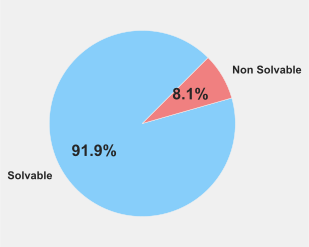

In [87]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(train_set)

**92 % des prêts ont été remboursés sur l'échantillon d'entrainement** => donc 8 % des individus ont été non solvables 

## 2. Nettoyage des données <a class="anchor" id="partie2"></a>

Dans cette partie, les jeu de données d'entrainement et de test sont concaténés pour traiter les features de manière conjointe

In [88]:
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """
    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = np.nan
    app = train_set.append(test_set, ignore_index = True, sort = False)
    return app

In [89]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_set, test_set)
app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,True
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,True


### 2.1 Variables catégorielles <a class="anchor" id="Section_2_1"></a>

#### Liste des variables catégorielles et modalités prises : identification des modalités différentes entre Train et Test

In [90]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """
    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Valeurs uniques dans Train:', app[~app['Test']][col].nunique())
            print('Valeurs uniques dans Test: ', app[app['Test']][col].nunique())
            print('Unique dans Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique dans Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [91]:
# Descriptif des variables catégorielles
display_cat_columns(app)

NAME_CONTRACT_TYPE
Valeurs uniques dans Train: 2
Valeurs uniques dans Test:  2
Unique dans Train:  ['Cash loans', 'Revolving loans']
Unique dans Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Valeurs uniques dans Train: 3
Valeurs uniques dans Test:  2
Unique dans Train:  ['F', 'M', 'XNA']
Unique dans Test:  ['F', 'M']


FLAG_OWN_CAR
Valeurs uniques dans Train: 2
Valeurs uniques dans Test:  2
Unique dans Train:  ['N', 'Y']
Unique dans Test:  ['N', 'Y']


FLAG_OWN_REALTY
Valeurs uniques dans Train: 2
Valeurs uniques dans Test:  2
Unique dans Train:  ['N', 'Y']
Unique dans Test:  ['N', 'Y']


NAME_TYPE_SUITE
Valeurs uniques dans Train: 7
Valeurs uniques dans Test:  7
Unique dans Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique dans Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Valeurs uniques dans Train: 8
Valeurs uniques d

##### Variable 'CODE_GENDER'

Le jeu d'entrainement contient seulement 4 valeurs nommés 'XNA' pour la colonne renseignant le genre. Ces emprunts sont supprimés

In [92]:
# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']

##### Variable 'NAME_INCOME_TYPE' 

La colonne 'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour le jeu d'entrainement , et pour seulement 5 emprunteurs. Les lignes renseignant ces emprunts sont supprimées 

In [93]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

##### Variable 'NAME_FAMILY_STATUS' 

De la même manière, pour la colonne NAME_FAMILY_STATUS, il y a seulement deux fois la valeur Unknown  et uniquement pour le jeu d'entrainement. Les lignes correspondantes sont supprimées

In [94]:
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

In [96]:
app.isnull().sum()

SK_ID_CURR                        0
TARGET                        48744
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_WEEK    47563
AMT_REQ_CREDIT_BUREAU_MON     47563
AMT_REQ_CREDIT_BUREAU_QRT     47563
AMT_REQ_CREDIT_BUREAU_YEAR    47563
Test                              0
Length: 123, dtype: int64

### 2.2 Variables numériques<a class="anchor" id="Section_2_2"></a>

##### Variable 'DAYS_EMPLOYED'

In [97]:
app['DAYS_EMPLOYED']

0         -637
1        -1188
2         -225
3        -3039
4        -3038
          ... 
356250   -5169
356251   -1149
356252   -3037
356253   -2731
356254    -633
Name: DAYS_EMPLOYED, Length: 356244, dtype: int64

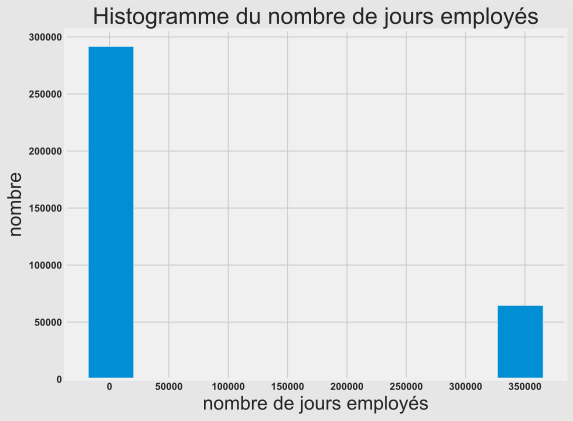

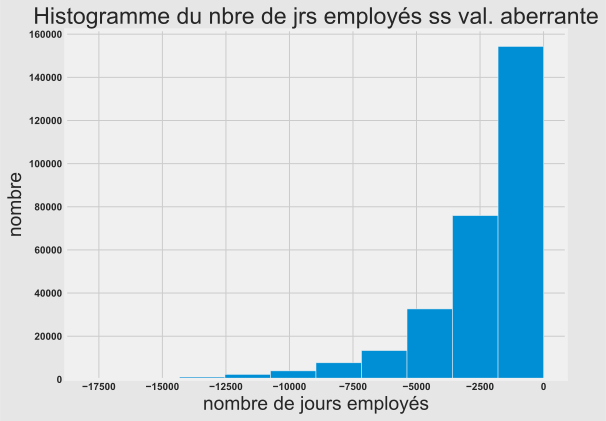

In [98]:
# on représente l'histogramme de la variable DAYS_EMPLOYED
fig = plt.figure(figsize = (8, 6),facecolor = '#E6E6E6')
ax = fig.add_subplot(111)
ax.grid()
app['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme du nombre de jours employés', fontsize = 10);
plt.xlabel('nombre de jours employés');
plt.ylabel('nombre')
plt.savefig('Hist_DAYS_EMPLOYED.png')

# on remplace la valeur aberrante 365243 par nan
fig = plt.figure(figsize = (8, 6),facecolor = '#E6E6E6')
ax = fig.add_subplot(111)
ax.grid()
app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme du nbre de jrs employés ss val. aberrante', fontsize = 10);
plt.xlabel('nombre de jours employés');
plt.ylabel('nombre')
plt.savefig('Hist_DAYS_EMPLOYED_sans valeur aberrante.png')

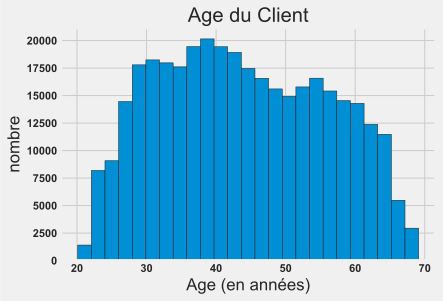

In [150]:
# Set the style of plots
plt.style.use('fivethirtyeight')
app['DAYS_BIRTH'] = app['DAYS_BIRTH']*-365
# Plot the distribution of ages in years
plt.hist(app['DAYS_BIRTH'], edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (en années)'); plt.ylabel('nombre')
plt.savefig('P7_Histo_AgeClient.png')

In [100]:
# Sauvegarde des résultats
app.to_csv(f'{MainDir2}/app_no_encoded_no_featureengineering.csv')

In [101]:
app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,True
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,True


### 2.3 Feature Engineering <a class="anchor" id="Section_2_3"></a>

#### 2.3.1 'Feature Engineering' automatisé <a class="anchor" id="sSection_2_3_1"></a>

In [102]:
# Create an entity set
es = ft.EntitySet(id = 'applications')

In [103]:
# Add dataframe to entityset
es = es.entity_from_dataframe(entity_id = 'applications', dataframe = app, index = 'SK_ID_CURR')

In [104]:
# Affiche le type de chaque colonne
es['applications']

Entity: applications
  Variables:
    SK_ID_CURR (dtype: index)
    TARGET (dtype: numeric)
    NAME_CONTRACT_TYPE (dtype: categorical)
    CODE_GENDER (dtype: categorical)
    FLAG_OWN_CAR (dtype: categorical)
    FLAG_OWN_REALTY (dtype: categorical)
    CNT_CHILDREN (dtype: numeric)
    AMT_INCOME_TOTAL (dtype: numeric)
    AMT_CREDIT (dtype: numeric)
    AMT_ANNUITY (dtype: numeric)
    AMT_GOODS_PRICE (dtype: numeric)
    NAME_TYPE_SUITE (dtype: categorical)
    NAME_INCOME_TYPE (dtype: categorical)
    NAME_EDUCATION_TYPE (dtype: categorical)
    NAME_FAMILY_STATUS (dtype: categorical)
    NAME_HOUSING_TYPE (dtype: categorical)
    REGION_POPULATION_RELATIVE (dtype: numeric)
    DAYS_BIRTH (dtype: numeric)
    DAYS_EMPLOYED (dtype: numeric)
    DAYS_REGISTRATION (dtype: numeric)
    DAYS_ID_PUBLISH (dtype: numeric)
    OWN_CAR_AGE (dtype: numeric)
    FLAG_MOBIL (dtype: numeric)
    FLAG_EMP_PHONE (dtype: numeric)
    FLAG_WORK_PHONE (dtype: numeric)
    FLAG_CONT_MOBILE (dtype: n

Certaines variables sont de type 'numeric' alors qu'elles devraient être de type 'boolean'.

Les types sont changés manuellement via le package FeatureTools

In [105]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean

# Manually define datatypes in app dataframe
variable_types = {
    'FLAG_MOBIL': BOOL,
    'FLAG_EMP_PHONE': BOOL,
    'FLAG_WORK_PHONE': BOOL,
    'FLAG_CONT_MOBILE': BOOL,
    'FLAG_PHONE': BOOL,
    'FLAG_EMAIL': BOOL,
    'REG_REGION_NOT_LIVE_REGION': BOOL,
    'REG_REGION_NOT_WORK_REGION': BOOL,
    'LIVE_REGION_NOT_WORK_REGION': BOOL,
    'REG_CITY_NOT_LIVE_CITY': BOOL,
    'REG_CITY_NOT_WORK_CITY': BOOL,
    'LIVE_CITY_NOT_WORK_CITY': BOOL,
    'FLAG_DOCUMENT_2': BOOL,
    'FLAG_DOCUMENT_3': BOOL,
    'FLAG_DOCUMENT_4': BOOL,
    'FLAG_DOCUMENT_5': BOOL,
    'FLAG_DOCUMENT_6': BOOL,
    'FLAG_DOCUMENT_7': BOOL,
    'FLAG_DOCUMENT_8': BOOL,
    'FLAG_DOCUMENT_9': BOOL,
    'FLAG_DOCUMENT_10': BOOL,
    'FLAG_DOCUMENT_11': BOOL,
    'FLAG_DOCUMENT_12': BOOL,
    'FLAG_DOCUMENT_13': BOOL,
    'FLAG_DOCUMENT_14': BOOL,
    'FLAG_DOCUMENT_15': BOOL,
    'FLAG_DOCUMENT_16': BOOL,
    'FLAG_DOCUMENT_17': BOOL,
    'FLAG_DOCUMENT_18': BOOL,
    'FLAG_DOCUMENT_19': BOOL,
    'FLAG_DOCUMENT_20': BOOL,
    'FLAG_DOCUMENT_21': BOOL,
}

# Add dataframe to entityset, using manual datatypes
es = es.entity_from_dataframe(entity_id = 'applications', dataframe = app, index = 'SK_ID_CURR', variable_types = variable_types)

In [106]:
# Affiche le type de chaque colonne
es['applications']

Entity: applications
  Variables:
    SK_ID_CURR (dtype: index)
    TARGET (dtype: numeric)
    NAME_CONTRACT_TYPE (dtype: categorical)
    CODE_GENDER (dtype: categorical)
    FLAG_OWN_CAR (dtype: categorical)
    FLAG_OWN_REALTY (dtype: categorical)
    CNT_CHILDREN (dtype: numeric)
    AMT_INCOME_TOTAL (dtype: numeric)
    AMT_CREDIT (dtype: numeric)
    AMT_ANNUITY (dtype: numeric)
    AMT_GOODS_PRICE (dtype: numeric)
    NAME_TYPE_SUITE (dtype: categorical)
    NAME_INCOME_TYPE (dtype: categorical)
    NAME_EDUCATION_TYPE (dtype: categorical)
    NAME_FAMILY_STATUS (dtype: categorical)
    NAME_HOUSING_TYPE (dtype: categorical)
    REGION_POPULATION_RELATIVE (dtype: numeric)
    DAYS_BIRTH (dtype: numeric)
    DAYS_EMPLOYED (dtype: numeric)
    DAYS_REGISTRATION (dtype: numeric)
    DAYS_ID_PUBLISH (dtype: numeric)
    OWN_CAR_AGE (dtype: numeric)
    OCCUPATION_TYPE (dtype: categorical)
    CNT_FAM_MEMBERS (dtype: numeric)
    REGION_RATING_CLIENT (dtype: numeric)
    REGION_RATI

Le changement de types s'est effectué correctement

In [107]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean
ID = ft.variable_types.Id

# Add bureau dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'bureau',
    dataframe = bureau,
    index = 'SK_ID_BUREAU',
    variable_types = {'SK_ID_CURR': ID})

# Add bureau_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'bureau_balance',
    dataframe = bureau_balance,
    index = 'New',
    variable_types = {'SK_ID_BUREAU': ID})

# Add cash_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'cash_balance',
    dataframe = cash_balance,
    index = 'New',
    variable_types = {'SK_ID_PREV': ID,
                      'SK_ID_CURR': ID})

# Add card_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'card_balance',
    dataframe = card_balance,
    index = 'New',
    variable_types = {'SK_ID_PREV': ID,
                      'SK_ID_CURR': ID})

# Add prev_app dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'prev_app',
    dataframe = prev_app,
    index = 'SK_ID_PREV',
    variable_types = {'SK_ID_CURR': ID,
                      'NFLAG_LAST_APPL_IN_DAY': BOOL})

# Add payments dataframe to entityset
es = es.entity_from_dataframe(
    entity_id = 'payments',
    dataframe = payments,
    index = 'New',
    variable_types = {'SK_ID_PREV': ID,
                      'SK_ID_CURR': ID})

C:\Users\ELBO CONSULTING\anaconda3\lib\site-packages\featuretools\entityset\entity.py:462: UserWarning:

index New not found in dataframe, creating new integer column



In [108]:
# Definit les relations entre dataframes
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('applications', 'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
  ('applications', 'SK_ID_CURR',    'prev_app',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'cash_balance',   'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'payments',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'card_balance',   'SK_ID_CURR')
]

# Create the relationships
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(ft.Relationship(es[pe][pv], es[ce][cv]))

In [109]:
# Define which primitives to use
agg_primitives = ['count', 'median']
trans_primitives = ['cum_sum']

In [110]:
# Run deep feature synthesis
app, features = ft.dfs(entityset=es,
                       target_entity = 'applications',
                       trans_primitives = trans_primitives,
                       agg_primitives = agg_primitives, 
                       verbose = True,
                       max_depth = 2)

Built 406 features
Elapsed: 16:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [111]:
# Liste de toutes les variables
app.columns.tolist()

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_M

In [112]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CUM_SUM(MEDIAN(prev_app.DAYS_FIRST_DUE)),CUM_SUM(MEDIAN(prev_app.DAYS_LAST_DUE)),CUM_SUM(MEDIAN(prev_app.DAYS_LAST_DUE_1ST_VERSION)),CUM_SUM(MEDIAN(prev_app.DAYS_TERMINATION)),CUM_SUM(MEDIAN(prev_app.HOUR_APPR_PROCESS_START)),CUM_SUM(MEDIAN(prev_app.NFLAG_INSURED_ON_APPROVAL)),CUM_SUM(MEDIAN(prev_app.RATE_DOWN_PAYMENT)),CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIMARY)),CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED)),CUM_SUM(MEDIAN(prev_app.SELLERPLACE_AREA))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-5.650000e+02,-2.500000e+01,1.250000e+02,-1.700000e+01,9.0,0.0,0.000000,NaN,NaN,500.0
100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,-1.362000e+03,-6.720000e+02,-5.220000e+02,-6.560000e+02,24.0,1.0,0.050030,NaN,NaN,700.0
100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-2.146000e+03,-1.396000e+03,-1.216000e+03,-1.370000e+03,29.0,1.0,0.262038,NaN,NaN,730.0
100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,-2.362000e+03,1.811500e+05,-5.620000e+02,1.811800e+05,44.0,1.0,0.425450,NaN,NaN,729.0
100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,-3.438000e+03,1.804040e+05,-1.308000e+03,1.804410e+05,57.0,2.0,0.584966,NaN,NaN,757.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,1.255346e+09,1.991025e+10,4.022546e+09,2.171472e+10,4272964.5,84454.5,NaN,NaN,NaN,103949499.5
456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,1.255344e+09,1.991025e+10,4.022545e+09,2.171472e+10,4272976.0,84455.0,24111.016181,NaN,NaN,103949578.0
456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,1.255344e+09,1.991043e+10,4.022545e+09,2.171490e+10,4272996.0,84455.0,24111.070649,NaN,NaN,103949724.0


In [113]:
# Remove low information features
app = selection.remove_low_information_features(app)
print("Le nombre de colonnes est de {}".format(len(app.columns)))

Le nombre de colonnes est de 406


In [114]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CUM_SUM(MEDIAN(prev_app.DAYS_FIRST_DUE)),CUM_SUM(MEDIAN(prev_app.DAYS_LAST_DUE)),CUM_SUM(MEDIAN(prev_app.DAYS_LAST_DUE_1ST_VERSION)),CUM_SUM(MEDIAN(prev_app.DAYS_TERMINATION)),CUM_SUM(MEDIAN(prev_app.HOUR_APPR_PROCESS_START)),CUM_SUM(MEDIAN(prev_app.NFLAG_INSURED_ON_APPROVAL)),CUM_SUM(MEDIAN(prev_app.RATE_DOWN_PAYMENT)),CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIMARY)),CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED)),CUM_SUM(MEDIAN(prev_app.SELLERPLACE_AREA))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-5.650000e+02,-2.500000e+01,1.250000e+02,-1.700000e+01,9.0,0.0,0.000000,NaN,NaN,500.0
100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,-1.362000e+03,-6.720000e+02,-5.220000e+02,-6.560000e+02,24.0,1.0,0.050030,NaN,NaN,700.0
100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-2.146000e+03,-1.396000e+03,-1.216000e+03,-1.370000e+03,29.0,1.0,0.262038,NaN,NaN,730.0
100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,-2.362000e+03,1.811500e+05,-5.620000e+02,1.811800e+05,44.0,1.0,0.425450,NaN,NaN,729.0
100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,-3.438000e+03,1.804040e+05,-1.308000e+03,1.804410e+05,57.0,2.0,0.584966,NaN,NaN,757.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,1.255346e+09,1.991025e+10,4.022546e+09,2.171472e+10,4272964.5,84454.5,NaN,NaN,NaN,103949499.5
456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,1.255344e+09,1.991025e+10,4.022545e+09,2.171472e+10,4272976.0,84455.0,24111.016181,NaN,NaN,103949578.0
456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,1.255344e+09,1.991043e+10,4.022545e+09,2.171490e+10,4272996.0,84455.0,24111.070649,NaN,NaN,103949724.0


#### 2.3.2 Feature Engineering manuel <a class="anchor" id="sSection_2_3_2"></a>

Cette étape de 'Feature Engineering' permet de créer de nouvelles features pertinentes issues de celles existantes pour aider le modèle :
   
   1. Le ratio temps travaillé/âge
   
   2. Le ratio crédit/revenu
   
   3. le ratio revenu/annuité
   
   4. le ratio revenu/annuité/âge
   
   5. le ratio crédit/annuité
   
   6. le ratio crédit/annuité/âge
   
   7. le ratio revenu membre du foyer
    


In [115]:
def manual_feature_engineering(app) :
    
    # Certaines compositions pertinentes de variables permettent d'aider le modèle
    
    app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
    app['CREDIT_TO_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL'] 
    app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']
    app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
    app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
    
    return app

In [116]:
# Feature engineering manuel
app = manual_feature_engineering(app)

In [118]:
# Sauvegarde des résultats
app.to_csv(f'{MainDir2}/app_no_encoded_featureengineering.csv')

In [119]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIMARY)),CUM_SUM(MEDIAN(prev_app.RATE_INTEREST_PRIVILEGED)),CUM_SUM(MEDIAN(prev_app.SELLERPLACE_AREA)),PROPORTION_LIFE_EMPLOYED,CREDIT_TO_INCOME_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,500.0,-24.575098,2.007889,8.198215,212.502215,16.461104,426.680836,202500.0
100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,700.0,-25.864599,4.790750,7.563343,347.395741,36.234085,1664.286145,135000.0
100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,730.0,-4.311929,2.000000,10.000000,521.808219,20.000000,1043.616438,67500.0
100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,729.0,-58.365430,2.316167,4.547522,236.782597,10.532818,548.427959,67500.0
100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,757.5,-55.632651,4.222222,5.556699,303.441432,23.461618,1281.197157,121500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,103949499.5,-94.475964,3.395556,6.953387,380.435971,23.610610,1291.791476,121500.0
456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,103949578.0,-37.491954,3.951829,4.935834,151.266413,19.505570,597.778934,39375.0
456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,103949724.0,-69.620965,1.555556,6.098387,266.023350,9.486380,413.814100,67500.0


### 2.4 Données manquantes <a class="anchor" id="Section_2_4"></a>

#### Proportions des données manquantes

In [130]:
def missing_values(df, display = False, printf = True, top_n_missing = 50, title = ""): 
    
    # Calcul de la proportion de données manquantes pour chaque colonne

    null_prop = df.isnull().sum(axis=0).sum()/len(df)/len(df.columns)*100
    null = df.isnull().sum(axis=0).sort_values()/len(df)*100
    
    if printf:
        print("Le pourcentage moyen de valeurs manquantes est de {:.2f}%".format(null_prop))
    
    # Si display = True, plot :
    if display :
        fig = plt.figure(figsize = (10, 6))
        plt.axhline(y = null_prop, color = 'k', linestyle = '--', lw = 2)
        plt.legend(['{:.2f}% global de données manquantes (TOP 50 variables)'.format(null_prop)], fontsize = 13)

        data_to_plot = pd.DataFrame(null).sort_values(by = 0, ascending=False)[0: top_n_missing]
        
        sns.barplot(data_to_plot.index, data_to_plot[0])
        plt.ylabel("%")
        plt.title(title)
#        labels = ['\n'.join(wrap(l, top_n_missing)) for l in data_to_plot.index]        
        labels = [l for l in data_to_plot.index]
        plt.xticks(range(len(labels)), labels, rotation = 'vertical')
        
        plt.show()
    else :
        return null

Le pourcentage moyen de valeurs manquantes est de 24.20%


C:\Users\ELBO CONSULTING\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



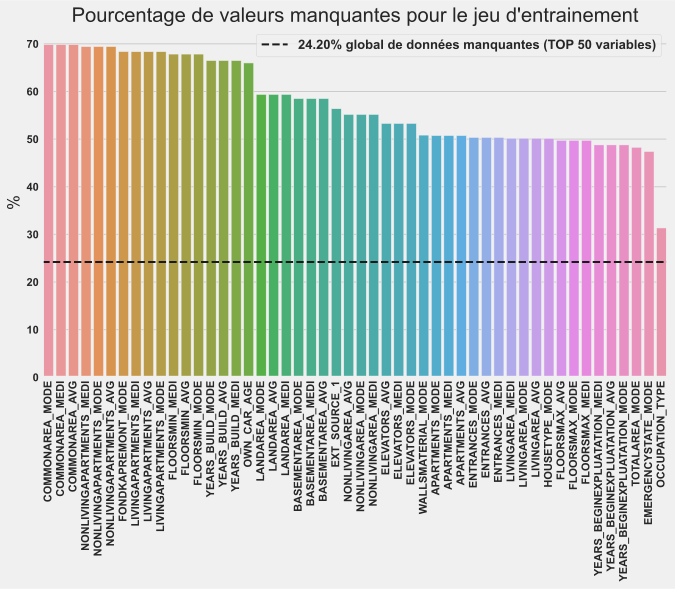

In [131]:
missing_values(train_set, display = True, title = "Pourcentage de valeurs manquantes pour le jeu d'entrainement")

Le pourcentage moyen de valeurs manquantes est de 24.24%


C:\Users\ELBO CONSULTING\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



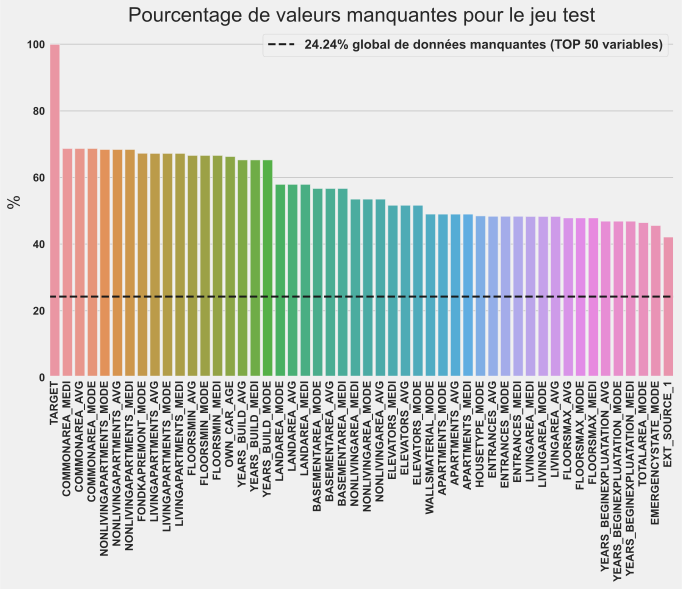

In [132]:
missing_values(test_set, display = True, title = "Pourcentage de valeurs manquantes pour le jeu test")

#### Suppression des valeurs manquantes

Les colonnes dont le taux de valeurs manquantes est supérieur à 90 % sont supprimés des données

In [133]:
def drop_missing_values(app):

    # On récupère les données d'entrainement
    train_set = app[app['Test'] == False]
    # On récupère les données test
    test_set = app[app['Test'] == False]
    
    # Détermine la proportion de valeurs manquantes pour les données d'entrainement
    missing_train = missing_values(train_set, printf = False)
    # Détermine la proportion de valeurs manquantes pour les données test
    missing_test = missing_values(test_set, printf = False)
    
    # Jeu d'entrainement - Défini la liste des variables dont les valeurs manquantes sont supérieurs à 90%
    var_missing_values_train = list(missing_train[missing_train > 90].index)
    # Jeu test - Défini la liste des variables dont les valeurs manquantes sont supérieurs à 90%
    var_missing_values_test = list(missing_test[missing_test > 90].index)
    # Concaténation des variables + suppression des doublons
    var_missing_values = list(set(var_missing_values_train + var_missing_values_test))
    
    # Suppression des colomnes dont les valeurs sont manquantes
    app.drop(columns = var_missing_values, inplace = True)
    
    # Affiche le nouveau pourcentage de valeurs manquantes
    null_prop = app.isnull().sum(axis = 0).sum()/len(app)/len(app.columns)*100

    print('Le nouveau pourcentage de valeurs manquantes est de {:.2f}%'.format(null_prop))
    return app

In [134]:
app = drop_missing_values(app)

Le nouveau pourcentage de valeurs manquantes est de 30.53%


In [135]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CUM_SUM(MEDIAN(prev_app.NFLAG_INSURED_ON_APPROVAL)),CUM_SUM(MEDIAN(prev_app.RATE_DOWN_PAYMENT)),CUM_SUM(MEDIAN(prev_app.SELLERPLACE_AREA)),PROPORTION_LIFE_EMPLOYED,CREDIT_TO_INCOME_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.000000,500.0,-24.575098,2.007889,8.198215,212.502215,16.461104,426.680836,202500.0
100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,1.0,0.050030,700.0,-25.864599,4.790750,7.563343,347.395741,36.234085,1664.286145,135000.0
100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,1.0,0.262038,730.0,-4.311929,2.000000,10.000000,521.808219,20.000000,1043.616438,67500.0
100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,1.0,0.425450,729.0,-58.365430,2.316167,4.547522,236.782597,10.532818,548.427959,67500.0
100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,2.0,0.584966,757.5,-55.632651,4.222222,5.556699,303.441432,23.461618,1281.197157,121500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,84454.5,NaN,103949499.5,-94.475964,3.395556,6.953387,380.435971,23.610610,1291.791476,121500.0
456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,84455.0,24111.016181,103949578.0,-37.491954,3.951829,4.935834,151.266413,19.505570,597.778934,39375.0
456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,84455.0,24111.070649,103949724.0,-69.620965,1.555556,6.098387,266.023350,9.486380,413.814100,67500.0


## 3. Encodage des variables catégorielles <a class="anchor" id="partie3"></a>

Les variables catégorielles doivent être encodés pour être utilisables par les modèles. Les variables cycliques comme les jours de la semaine sont encodées en deux dimensions, les variables contenant uniquement 2 classes sont assignées à des 0 ou et des 1. Pour les variables à plus de 2 classes, un one-hot encoding est appliqué.

### 3.1 Encondage des 'variables temporelles' <a class="anchor" id="Section_3_1"></a>

La colomne 'WEEKDAY_APPR_PROCESS_START' contient des informations catégorielles concernant le jour de la semaine. Une manière communément utilisée en ML est d'encoder la variable en deux dimensions en utilisant un système de coordonnées polaires. Les jours de la semaine sont alors représentés sur un cercle et le nombre de dimensions est réduit par rapport à un one-hot-encoding.

In [136]:
def polar_projection(app, col):

    # Create map from categories to polar projection
    DOW_map = {
        'MONDAY':    0,
        'TUESDAY':   1,
        'WEDNESDAY': 2,
        'THURSDAY':  3,
        'FRIDAY':    4,
        'SATURDAY':  5,
        'SUNDAY':    6,
    }
    DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
    DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

    # Show encoding of days of week -> circle
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    tt = np.linspace(0, 2*np.pi, 200)
    xx = np.cos(tt)
    yy = np.sin(tt)
    plt.plot(xx, yy)
    plt.gca().axis('equal')
    plt.xlabel('Dimension encodée 1')
    plt.ylabel('Dimension encodée 2')
    plt.title('Projection 2D des jours de la semaine')
    for day in days:
        plt.text(DOW_map1[day], DOW_map2[day], day, ha = 'center')
    plt.show()
    
    # WEEKDAY_APPR_PROCESS_START to polar coords
    app[col + '_1'] = app[col].map(DOW_map1)
    app[col + '_2'] = app[col].map(DOW_map2)
    app.drop(columns=col, inplace=True)
    
    return app

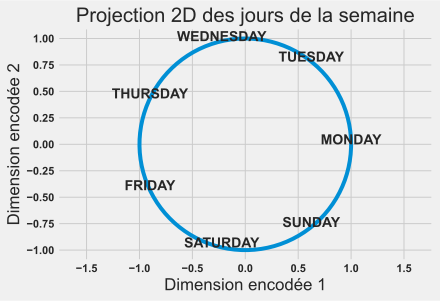

In [137]:
app = polar_projection(app, col = 'WEEKDAY_APPR_PROCESS_START')

In [138]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CUM_SUM(MEDIAN(prev_app.SELLERPLACE_AREA)),PROPORTION_LIFE_EMPLOYED,CREDIT_TO_INCOME_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,500.0,-24.575098,2.007889,8.198215,212.502215,16.461104,426.680836,202500.0,-0.222521,0.974928
100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,700.0,-25.864599,4.790750,7.563343,347.395741,36.234085,1664.286145,135000.0,1.000000,0.000000
100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,730.0,-4.311929,2.000000,10.000000,521.808219,20.000000,1043.616438,67500.0,1.000000,0.000000
100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,729.0,-58.365430,2.316167,4.547522,236.782597,10.532818,548.427959,67500.0,-0.222521,0.974928
100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,757.5,-55.632651,4.222222,5.556699,303.441432,23.461618,1281.197157,121500.0,-0.900969,0.433884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,103949499.5,-94.475964,3.395556,6.953387,380.435971,23.610610,1291.791476,121500.0,-0.222521,0.974928
456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,103949578.0,-37.491954,3.951829,4.935834,151.266413,19.505570,597.778934,39375.0,1.000000,0.000000
456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,103949724.0,-69.620965,1.555556,6.098387,266.023350,9.486380,413.814100,67500.0,-0.222521,0.974928


Cet encodage conserve le caractère cyclique des jours de la semaine, tout en limitant le nombre de dimensions.

### 3.2 Encodage des autres variables catégorielles <a class="anchor" id="Section_3_2"></a>

For the housing-related features (e.g. LIVINGAPARTMENTS_MODE, BASEMENTAREA_AVG, etc) there are combinations of some PREFIX (e.g. LIVINGAPARTMENTS, BASEMENTAREA, etc) and some POSTFIX (e.g. MODE, MEDI, AVG, etc) into a variable PREFIX_POSTFIX. However, if one value for a given PREFIX is empty, the other values for that PREFIX will also be empty.

For each column which has some empty values, we want to add an indicator column which is 1 if the value in the corresponding column is empty, and 0 otherwise. However, if we do this with the housing-related features, we'll end up with a bunch of duplicate columns! This is because the same samples have null values across all the POSTFIX columns for a given PREFIX. The same problem crops up with the CREDIT_BUREAU-related features. To handle this problem, after creating the null indicator columns, we'll check for duplicate columns and merge them.

So, first we'll add columns to indicate where there are empty values in each other column.

Then we can label encode categorical features with only 2 possible values (that is, turn the labels into either 0 or 1).

Then we'll one-hot encode the categorical features which have more than 2 possible values.

In [139]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        print(col)
        if col != 'Test' and col != 'TARGET':
            if app[col].dtype == object: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    app[col] = label_encoder.fit_transform(app[col])
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
       
    return app

In [140]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        if col != 'Test' and col != 'TARGET':
            # Add indicator columns for empty values
            app_null = app[col].isnull()
            if app_null.sum() > 0:
                app[col + '_ISNULL'] = app_null
                col_to_del.append(col + '_ISNULL')

            if app[col].dtype == object: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    if col + '_ISNULL' in app.columns:  # missing values here?
                        app.loc[app[col + '_ISNULL'], col] = 'NaN'
                    app[col] = label_encoder.fit_transform(app[col])
                    if col + '_ISNULL' in app.columns:  # re-remove missing vals
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
    
    # Suppresion des colonnes nulles          
    app.drop(columns=col_to_del, inplace=True)
    
    return app

In [141]:
# Encondage des variables catégorielles
app = cat_encoder(app)

In [142]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
100003,0.0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,1,0,0,0,0,0,0
100004,0.0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
100006,0.0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
100007,0.0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,0,0,0,1,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
456222,NaN,0,0,0,0,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
456223,NaN,0,0,1,1,1,202500.0,315000.0,33205.5,315000.0,...,1,0,0,0,0,0,0,0,1,0


#### Sauvegarde des données pré-traités en fichier csv

In [143]:
# Sauvegarde des données
app.to_csv(f'{MainDir2}/app_encoded.csv')

In [144]:
app

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
100003,0.0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,1,0,0,0,0,0,0
100004,0.0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
100006,0.0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
100007,0.0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,0,0,0,1,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0,0,0,0,0,0
456222,NaN,0,0,0,0,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,0,0,0,0,0,0
456223,NaN,0,0,1,1,1,202500.0,315000.0,33205.5,315000.0,...,1,0,0,0,0,0,0,0,1,0


In [145]:
# on selectionne un échantillon des données en cas de traitement chronophage
app1 = app.sample(frac = 0.1, axis = 0)

In [146]:
app1

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
107013,NaN,0,1,1,1,0,171000.0,792162.0,33691.5,630000.0,...,1,0,0,0,0,0,1,0,0,0
332938,0.0,0,1,1,1,0,157500.0,157500.0,16668.0,157500.0,...,1,0,0,0,0,0,0,1,0,0
139873,0.0,0,1,1,1,0,135000.0,539059.5,27909.0,499500.0,...,0,0,0,0,0,0,0,0,0,0
307606,0.0,0,0,0,1,0,225000.0,140746.5,13711.5,121500.0,...,1,0,0,0,0,0,0,1,0,0
277170,NaN,0,0,0,1,1,112500.0,615888.0,64804.5,585000.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187376,0.0,0,0,0,1,0,202500.0,267102.0,20799.0,247500.0,...,0,0,0,0,0,0,0,0,0,0
200480,0.0,1,1,0,1,0,67500.0,180000.0,9000.0,180000.0,...,1,0,0,0,0,0,0,0,1,0
442158,NaN,0,0,1,0,0,157500.0,1004575.5,38002.5,778500.0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
# Sauvegarde des données
app1.to_csv(f'{MainDir2}/app1_encoded.csv')

In [148]:
fin  = datetime.datetime.now()
print('fin traitement : ', fin)

fin traitement :  2022-01-04 17:01:18.663335
